In [1]:
"""Data inspection."""

'Data inspection.'

In [24]:
import csv
import glob
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation
import nibabel
import os
import sklearn
import shutil

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

import importlib
import analyze
importlib.reload(analyze)
import datasets
importlib.reload(datasets)
import vis
importlib.reload(vis)

NEURO_DIR = '/neuro/'
TRAIN_VAL_DIR = os.path.join(NEURO_DIR, 'train_val_datasets')
OUTPUT = '/scratch/users/nmiolane/output_fmri_latent_dim_3'
DEVICE='cuda'

IMG_SHAPE = (96, 96)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)
TRAIN_IMG_PATH = os.path.join(TRAIN_VAL_DIR, 'train_fmri_%s.npy' % SHAPE_STR)

### Inspect MakeDataset

WARNING: There are no more images in the saved trained images

Loading /neuro/train_val_datasets/train_fmri_96x96.npy
Dataset shape: (12437, 1, 96, 96)


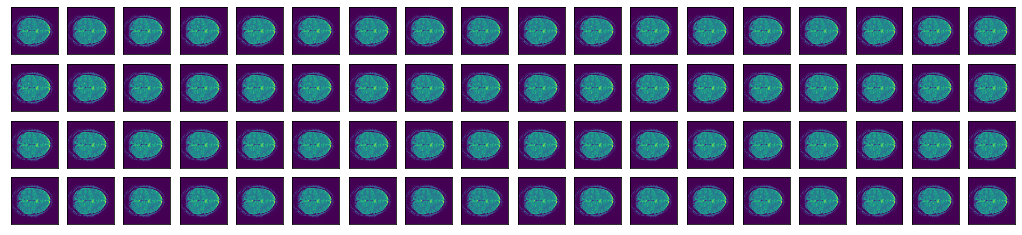

In [25]:
vis.show_data(TRAIN_IMG_PATH, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


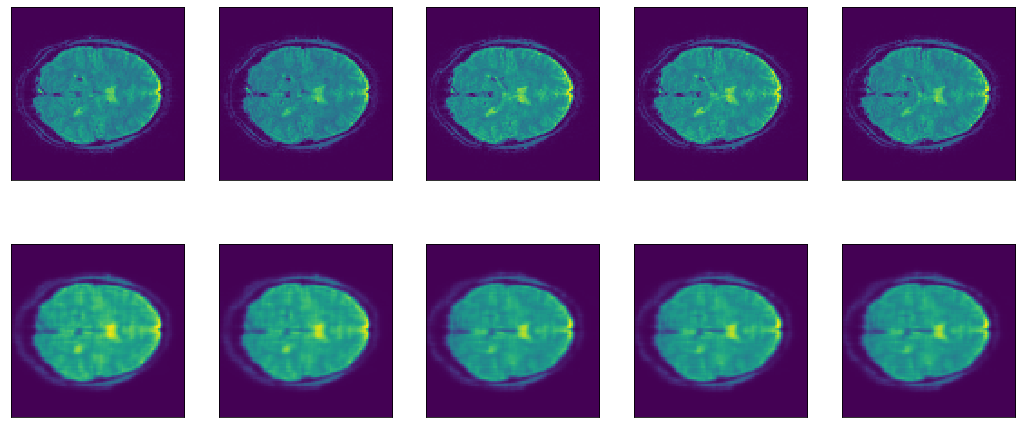

In [26]:
epoch_id=1
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


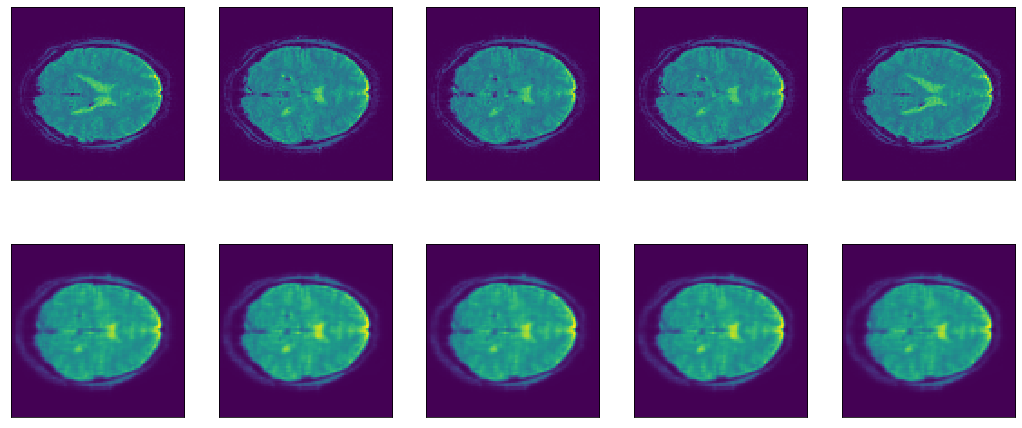

In [27]:
epoch_id=2
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


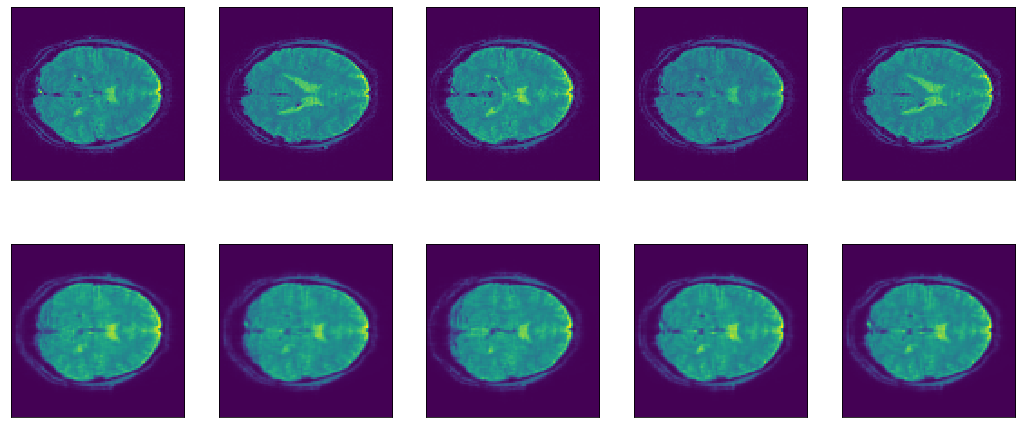

In [28]:
epoch_id=5
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


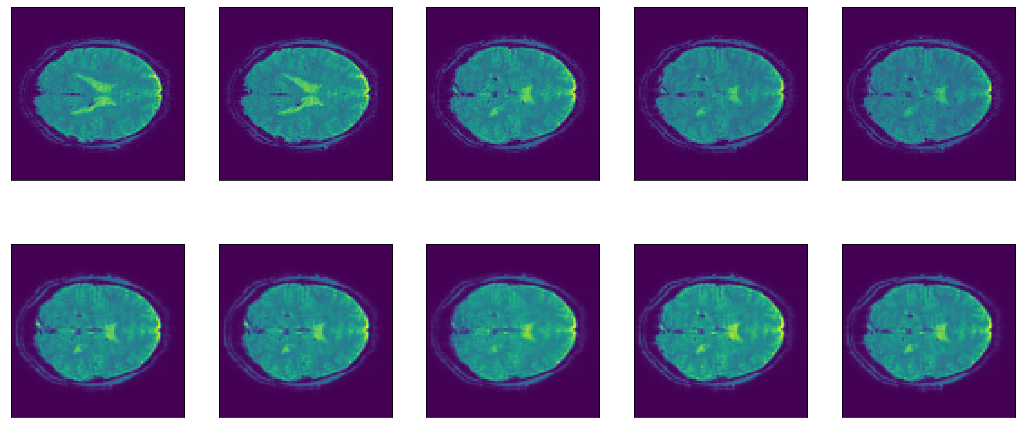

In [29]:
epoch_id=10
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


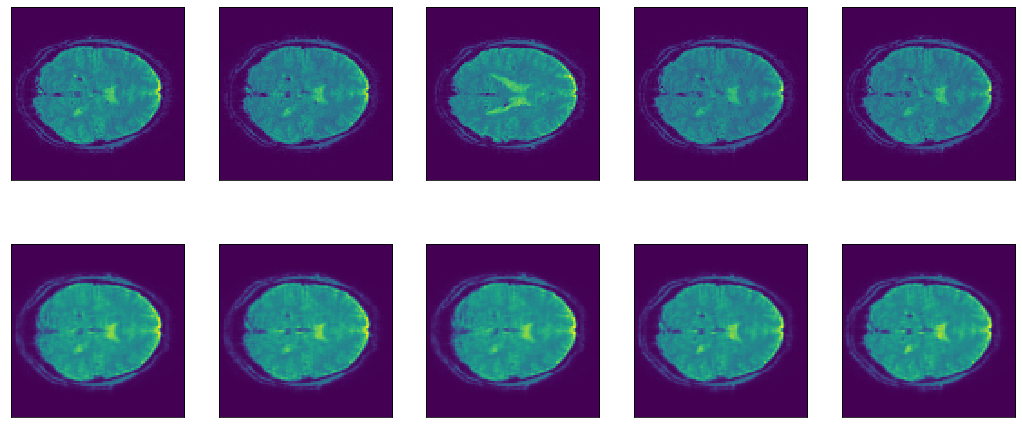

In [30]:
epoch_id=20
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


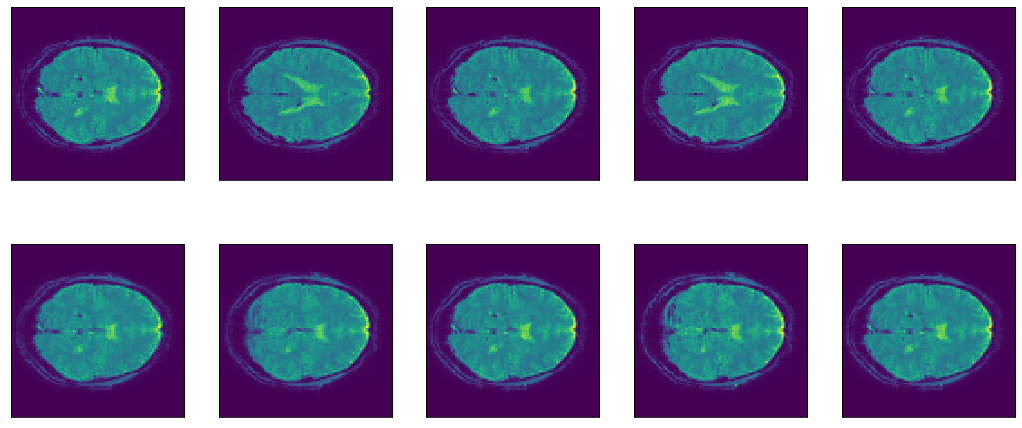

In [31]:
epoch_id=50
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


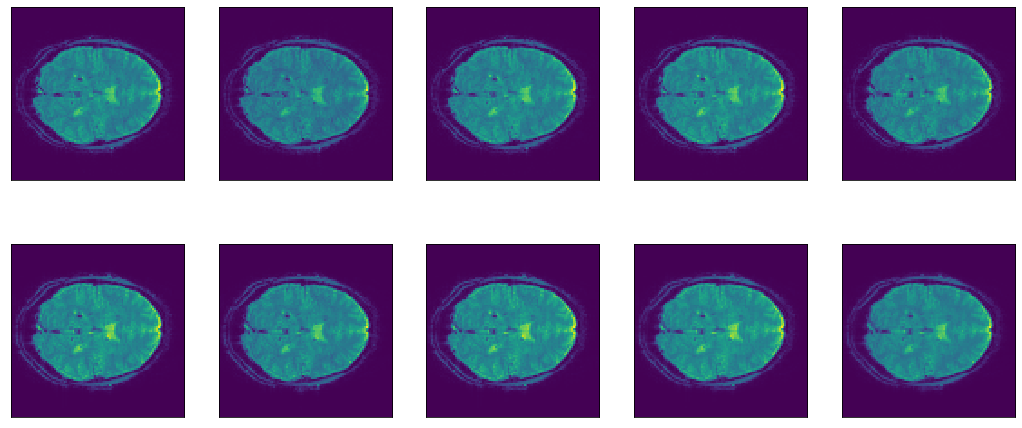

In [32]:
epoch_id=100
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


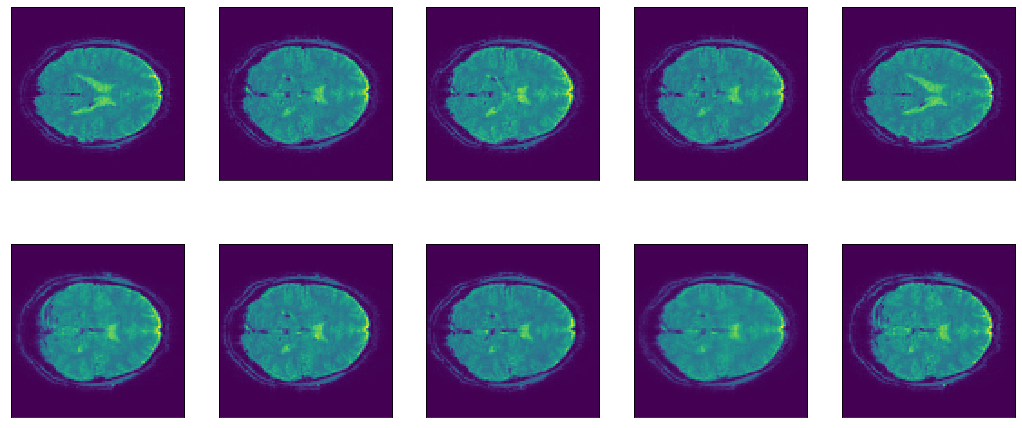

In [33]:
epoch_id=140
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

### Inspect training

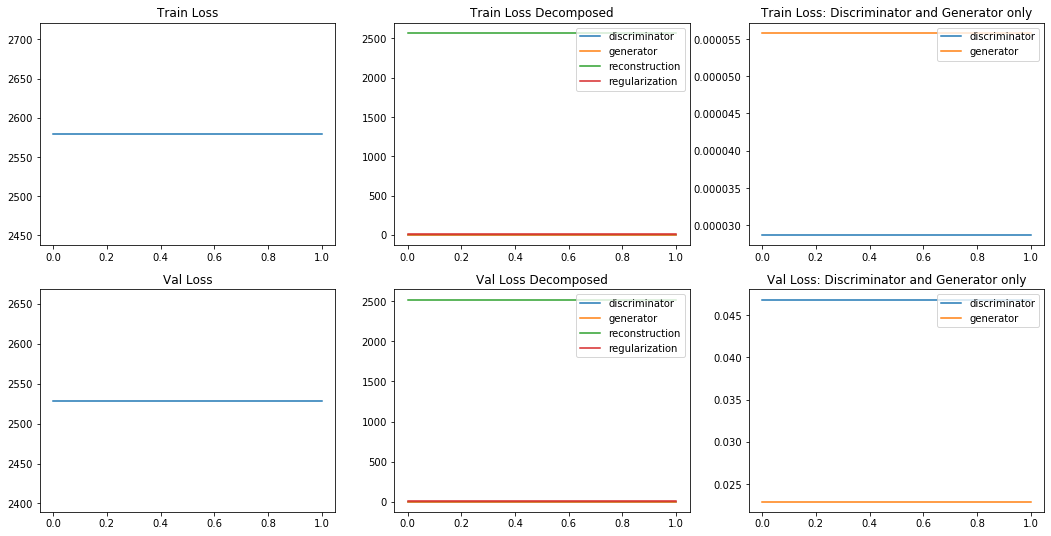

In [6]:
epoch_id = 1
vis.plot_losses(OUTPUT, epoch_id=epoch_id)

# 2. Inspect the latent space

## Standard PCA on the means of the approximation of the posterior

### Load test set and compute latent codes

In [19]:
def get_session(test_csv, ses_id):
    test_paths = []
    tasks = []
    times = []

    with open(test_csv, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            path, ses, task, run, time = row
            if path == 'path':
                continue
            if task != 'rest':
                continue
            if int(run) != 1:
                # Only take one run per session
                continue
            if int(ses) != ses_id:
                # Only take the session id
                continue
            test_paths.append(path)
            tasks.append(task)
            times.append(int(time))
        
    subset = [np.load(path) for path in test_paths]
    subset = np.array(subset)
    subset = np.expand_dims(subset, axis=1)
    N_PCA_COMPONENTS = 2

    # Note: the test dataset needs to be unshuffled here
    mus = analyze.latent_projection(OUTPUT, subset)
    projected_mus = analyze.pca_projection(mus, N_PCA_COMPONENTS)

    return projected_mus, tasks, times

## Gaussian Kernel Density Estimation

In [20]:
TIME_MAX = 600

TASK_TO_MARKER = {
    'rest': 'o',
    'breathhold': 'x',
    'dotstop': 'v',
    'eyesopen': '*',
    'languagewm': '^',
    'nback': '<',
    'objects': 'p',
    'retinotopy': 'P',
    'spatialwm': 'D'
}

SES_TO_MARKER = {
    2: 'o',
    3: 'x',
    4: 'v',
    5: 'D',
    10: 'P',
    11: 'p',
    12: 's',
    13: '*'
}

colormap = cm.get_cmap('viridis')
COLORS = colormap(np.linspace(start=0., stop=1., num=TIME_MAX))

def plot_session(ax, test_csv, ses_id, label=''):
    projected_mus, tasks, times = get_session(test_csv, ses_id)

    ax.plot(projected_mus[:, 0], projected_mus[:, 1], label=label)
    for mu, task, time in zip(projected_mus, tasks, times):
        c = np.array([COLORS[time-1]])[0]
        im = ax.plot(mu[0], mu[1], marker=SES_TO_MARKER[ses_id], c=c)
    return im, ax

2
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_150_encoder_train_loss_2513.5267_val_loss_2537.9545.pth


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

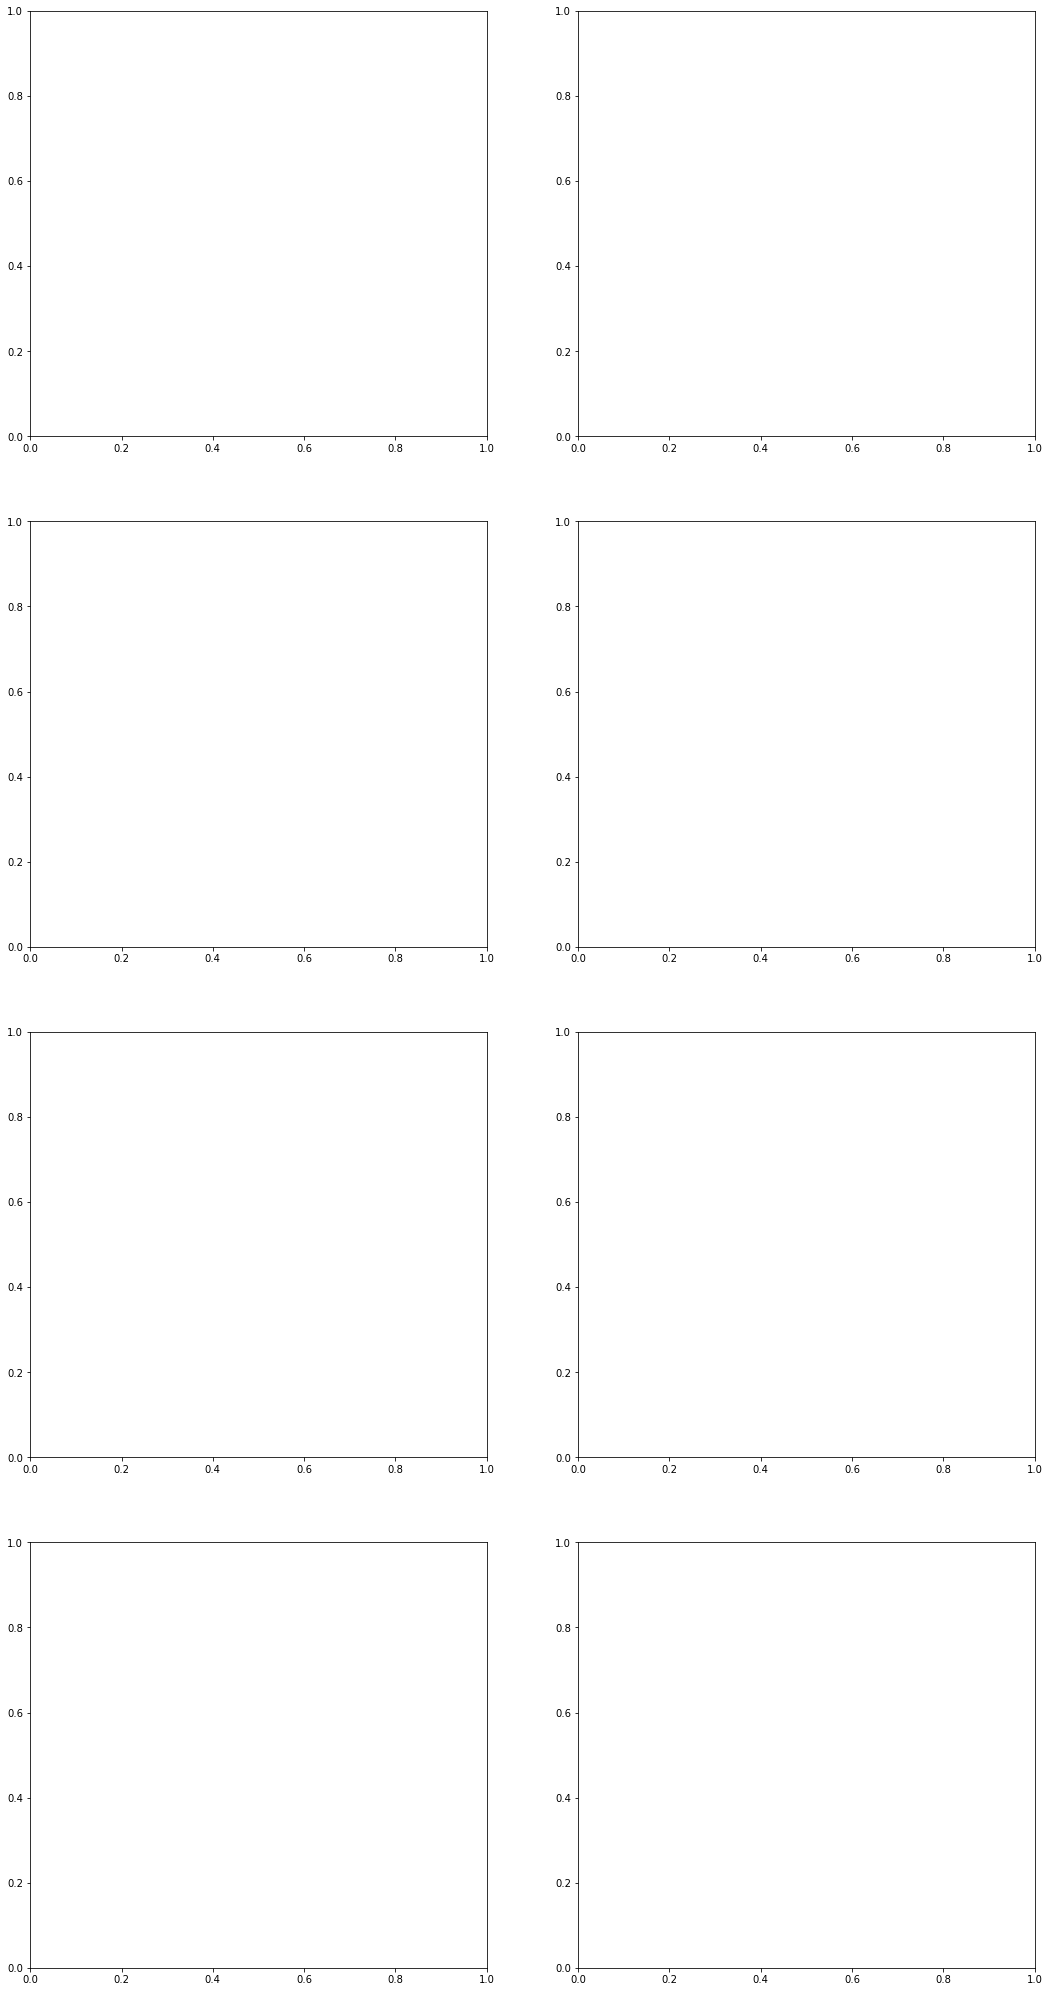

In [23]:
train_csv_path = '/neuro/train_val_datasets/train_fmri_%s_labels.csv' % SHAPE_STR

nrows = 4
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 36))


for i_ses, ses_id in enumerate([2, 3, 4, 5, 10, 11, 12, 13]):
    print(ses_id)
    ax = axes[int(i_ses // ncols), int(i_ses % ncols)]
    plot_session(ax, train_csv_path, ses_id, label='Session %d' % ses_id)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.legend()

2
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
3
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
4
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
5
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
10
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
11
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
12
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
13
Last checkpoint:  /scratch/users/nmiolane/output_fmri/tr

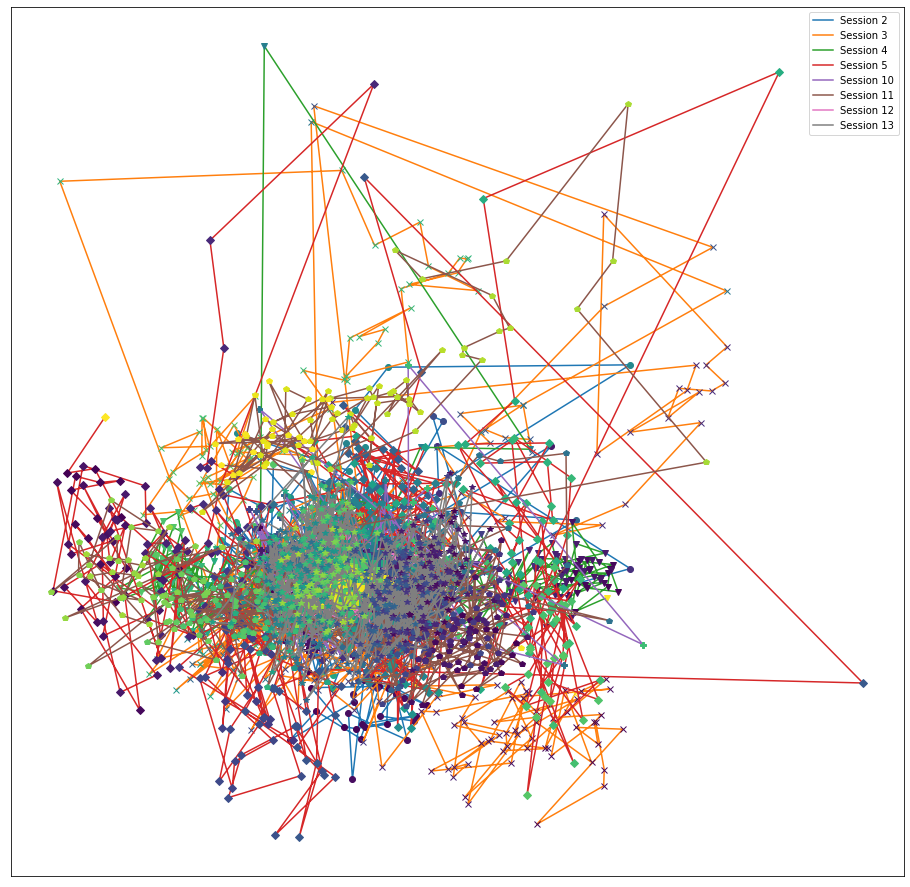

In [231]:
train_csv_path = '/neuro/train_val_datasets/train_fmri_128x128_labels.csv'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))

for ses_id in [2, 3, 4, 5, 10, 11, 12, 13]:
    print(ses_id)
    im, ax = plot_session(ax, train_csv_path, ses_id, label='Session %d' % ses_id)

ax.legend()
    
#cb = fig.colorbar(im[0], ax=ax, orientation='horizontal')
#focus = cb.set_label('Time')
#yticklabels = cb.ax.set_xticklabels([])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


5
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
10
Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth


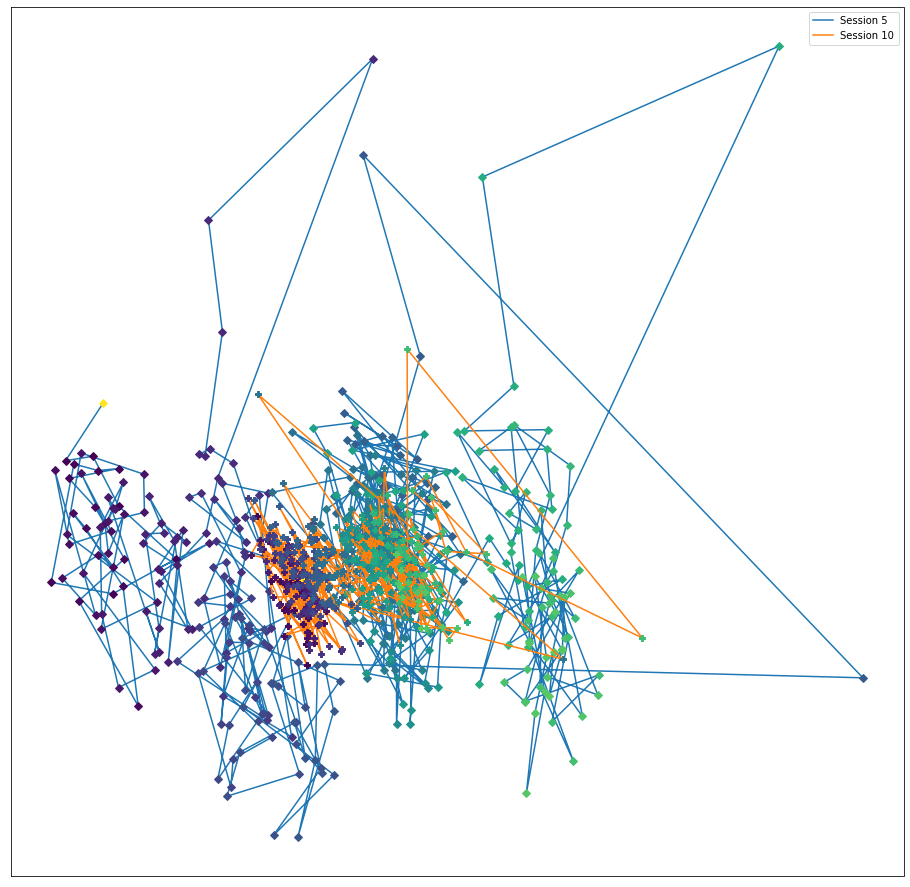

In [235]:
train_csv_path = '/neuro/train_val_datasets/train_fmri_128x128_labels.csv'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))

for ses_id in [5, 10]:
    print(ses_id)
    im, ax = plot_session(ax, train_csv_path, ses_id, label='Session %d' % ses_id)

ax.legend()

#cb = fig.colorbar(im, ax=ax, orientation='horizontal')
#focus = cb.set_label('Time')
#yticklabels = cb.ax.set_xticklabels([])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Fit a Gaussian Mixture

INFO:root:Found 106 sessions of rfMRIs: Divide in 75 train, 21 val and 10 test sessions

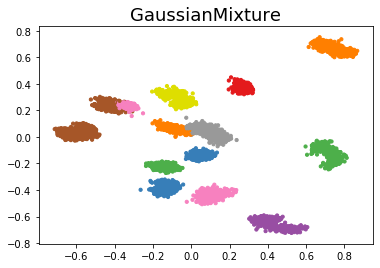

In [31]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# Clustering
X = projected_mus
n_components = 13

#X = StandardScaler().fit_transform(X)
gmm = mixture.GaussianMixture(
    n_components=n_components, covariance_type='full')
algorithm = gmm
name = 'GaussianMixture'
    
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    print('test')
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)

fig, ax = plt.subplots(1, 1)
ax.set_title(name, size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                      '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

#ax.xlim(-4, 4)
#ax.ylim(-5, 5)
#ax.xticks(())
#ax.yticks(())

plt.show()

### Interactive exploration of PCA in each cluster

In [26]:
print(torch.__version__)

1.1.0


In [35]:
epoch_id = 19

stds = np.zeros(N_COMPONENTS)
for i in range(N_COMPONENTS):
    stds[i] = np.std(projected_mus[:,i])
    
decoder = vis.load_module(OUTPUT, 'decoder', epoch_id)


projected = {}
pcas = {}
for i in range(n_components):
    print('Cluster: %d' % i)
    cluster = mus[y_pred==i]
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(cluster)
    projected[i] = pca.transform(cluster)
    pcas[i] = pca

    @interact(
        c1=FloatSlider(min=-3,max=3,step=0.1,value=0), 
        c2=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c3=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c4=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c5=FloatSlider(min=-3,max=3,step=0.1,value=0))
    def display_image(c1, c2, c3, c4, c5):
        z = (c1 * pca.components_[0]
             + c2 * pca.components_[1]
             + c3 * pca.components_[2]
             + c4 * pca.components_[3]
             + c5 * pca.components_[4])
        z = torch.Tensor(z).cuda()
        recon, _ = decoder(z)
        recon = recon.squeeze()
        plt.imshow(recon.detach().cpu(), cmap='gray')

Loading: /scratch/users/nmiolane/output/training/models/epoch_19_decoder_train_loss_5893.4182_val_loss_11365.7494.pth
Cluster: 0


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 1


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 2


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 3


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 4


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 5


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 6


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 7


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 8


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 9


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 10


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 11


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 12


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

### PCA in each cluster

In [34]:
fig = plt.figure(figsize=(20, 50))
plt.tight_layout()
r = 4
n_cols = 2 * r + 1 

projected = {}
pcas = {}
cmaps = ['Blues', 'Purples', 'Greens', 'Oranges', 'Reds']
for i in range(n_clusters):
    cluster = mus[y_pred==i]
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(cluster)
    projected[i] = pca.transform(cluster)
    pcas[i] = pca

    for id in range(N_COMPONENTS):
        for slider in range(-r, r+1, 1):
            plt.subplot(n_clusters*N_COMPONENTS, n_cols, i * N_COMPONENTS * n_cols + id * n_cols + slider + r + 1)
            z = slider * pca.components_[id]
            z = torch.Tensor(z).cuda()
            recon, _ = decoder(z)
            recon = recon.squeeze()
            plt.imshow(recon.detach().cpu(), cmap=cmaps[i])

NameError: name 'n_clusters' is not defined

<Figure size 1440x3600 with 0 Axes>

# 3. Inspect report created by pipeline

In [49]:
import os
import pylab

report_dir = '/scratch/users/nmiolane/output/report'
losses_path = os.path.join(report_dir, 'losses.png')
images_path = os.path.join(report_dir, 'images.png')
report_path = os.path.join(report_dir, 'report.html')

plt.figure()
img = pylab.imread(losses_path)
plt.imshow(img, aspect='auto')
plt.axis('off')

plt.figure(figsize=(30, 60))
img = pylab.imread(images_path)
plt.imshow(img)
plt.axis('off')


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/nmiolane/output/report/losses.png'

<Figure size 432x288 with 0 Axes>

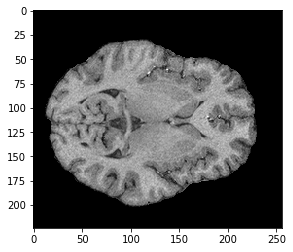

In [3]:
import nibabel
path = '/tmp/_oyiw_36_defBrainExtractionBrain.nii.gz'
img = nibabel.load(path)
array = img.get_fdata()
array = np.nan_to_num(array)
plt.imshow(array[:,:,120], cmap='gray')